In [40]:
import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore")

import os
import logging
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
sns.set()
%matplotlib inline


# custom functions
import sys
sys.path.append("/Users/user/Pharmaceutical_Sales_prediction")
from scripts import util
from scripts import plot

In [41]:
### Logger
log = logging.getLogger()
log.info('check')

INFO:root:check


In [42]:
## Read Datas

store_file = '../data/store.csv'
test_file = '../data/test.csv'
train_file = '../data/train.csv'

In [43]:
store_df = pd.read_csv(store_file, low_memory = False)

In [44]:
train_df = pd.read_csv(train_file, parse_dates = True, low_memory = False)

In [45]:
test_df = pd.read_csv(test_file, parse_dates = True, low_memory = False)

### Info About Datasets

In [46]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [47]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [48]:
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             41088 non-null  int64         
 1   Store          41088 non-null  int64         
 2   DayOfWeek      41088 non-null  int64         
 3   Date           41088 non-null  datetime64[ns]
 4   Open           41077 non-null  float64       
 5   Promo          41088 non-null  int64         
 6   StateHoliday   41088 non-null  object        
 7   SchoolHoliday  41088 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


In [49]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [50]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [51]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [52]:
# data extraction
# !!!!! HOW !!!!!
# train_df['Date'] = pd.to_datetime(train_df['Date'])
# train_df['Year'] = train_df['Date'].dt.year
# train_df['Month'] = train_df.index.month
# train_df['Day'] = train_df.index.day
# train_df['WeekOfYear'] = train_df.index.weekofyear
# len(train_df.index.week)
# train_df.index.week

'''
https://stackoverflow.com/questions/55776571/how-to-split-a-date-column-into-separate-day-month-year-column-in-pandas
'''


'\nhttps://stackoverflow.com/questions/55776571/how-to-split-a-date-column-into-separate-day-month-year-column-in-pandas\n'

### Null Percentages

In [53]:
print(f"Store Null Percentage : {util.get_null_percentage(store_df)} %")
print(f"Train Null Percentage : {util.get_null_percentage(train_df)} %")
print(f"Test Null Percentage : {util.get_null_percentage(test_df)} %")

INFO:root:util.py - calculate null percentage: 21.01


Store Null Percentage : 21.01 %


INFO:root:util.py - calculate null percentage: 0.0
INFO:root:util.py - calculate null percentage: 0.0


Train Null Percentage : 0.0 %
Test Null Percentage : 0.0 %


#### View Null Columns count

In [54]:
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [55]:
# No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values
store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median(), inplace = True)

In [56]:
store_df.fillna(0, inplace = True)
store_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [57]:
### Closed stores with no sales will not be counted for forcaset
# train_df = train_df[(train_df.Open != 0) & (train_df.Sales != 0)]
train_df = util.add_month_year(train_df)
train_df.head()


INFO:root:util.py - Year, Month, Day, WeekOfYear for Dataframe


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31


In [58]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
print("In total: ", train_store.shape)
train_store = pd.merge(train_df, store_df, how='inner', on='Store')
train_store['StateHoliday'] = train_store['StateHoliday'].apply(lambda x: str(x))
train_store

Joining train set with an additional store information.
In total:  (1017209, 22)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,2013,...,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,2013,...,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,2013,...,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,2013,...,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [59]:
print(f"Null Percentage of Train and Score : {util.get_null_percentage(train_store)} %")
# train_store.to_csv('../data/clean_train_store.csv', index=False)

INFO:root:util.py - calculate null percentage: 0.0


Null Percentage of Train and Score : 0.0 %


In [60]:
test_df = util.add_month_year(test_df)
test_df.head()

INFO:root:util.py - Year, Month, Day, WeekOfYear for Dataframe


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,17,38
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9,17,38
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9,17,38
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9,17,38
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9,17,38


## Getting Insightes

### Check for distribution in both training and test sets - are the promotions distributed similarly between these two groups?

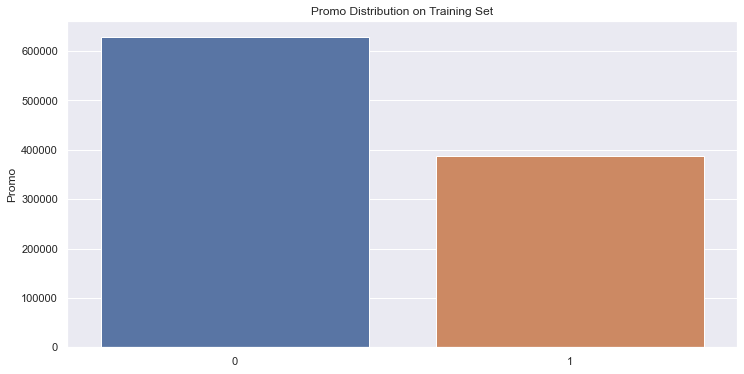

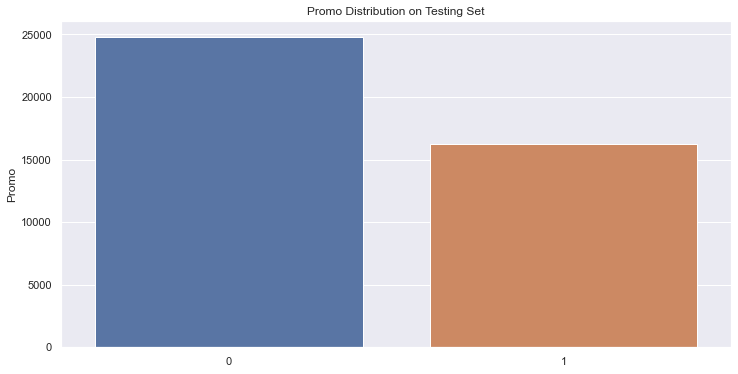

In [23]:
train_distribution = train_df.Promo.value_counts()
test_distribution = test_df.Promo.value_counts()

plot.bar(train_distribution.index, train_distribution, "Promo Distribution on Training Set")
plot.bar(test_distribution.index, test_distribution, "Promo Distribution on Testing Set")

### !!!! Check & compare sales behavior before, during and after holidays !!!

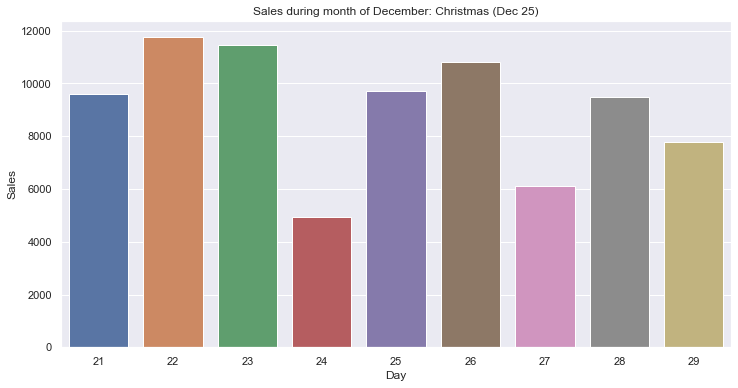

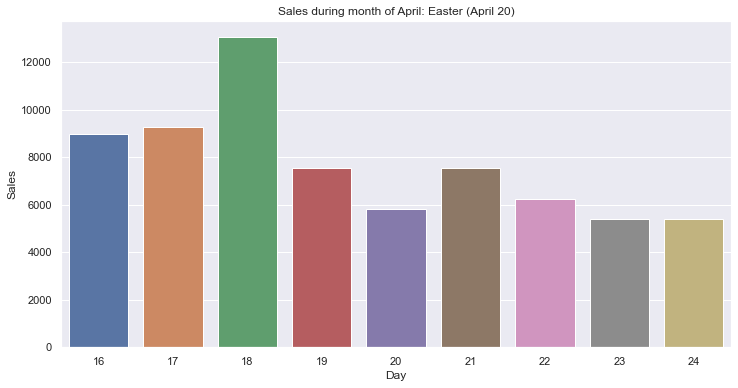

In [24]:
open_store = train_store[(train_store.Open == 1) & (train_store.Year == 2014)]

christmass_month = 12
eastern_month = 4

christmass_month = open_store[open_store.Month == christmass_month]
eastern_month = open_store[open_store.Month == eastern_month]

# plot.bar(chris['Day'], chris['Sales'], 'Sales during month of December: Christmas (Dec 25)')
# plot.bar(eastern['Day'], eastern['Sales'], 'Sales during month of April: Eastern (April 20)')

around_christmas = christmass_month[(christmass_month['Day'] > 20) & (christmass_month['Day'] < 30)]
around_christmas = around_christmas[['Day', 'Sales']].groupby('Day').mean()


around_eastern = eastern_month[(eastern_month['Day'] > 15) & (eastern_month['Day'] < 25)]
around_eastern = around_eastern[['Day', 'Sales']].groupby('Day').mean()

plot.bar(around_christmas.index, around_christmas['Sales'], 'Sales during month of December: Christmas (Dec 25)')
plot.bar(around_eastern.index, around_eastern['Sales'], 'Sales during month of April: Easter (April 20)')

Insight:-> There were more sales before and after the Holidays, rather than on the holidays

### What can you say about the correlation between sales and number of customers?

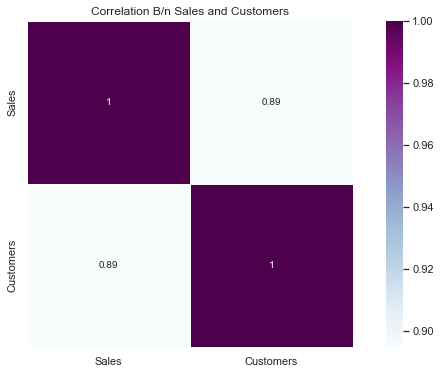

In [25]:
plot.heatmap(train_store[['Sales', 'Customers']], title='Correlation B/n Sales and Customers')

Insight :-> There is a high correlation b/n Sales and Customers. The more customers the more sales

### How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers

<Figure size 864x504 with 0 Axes>

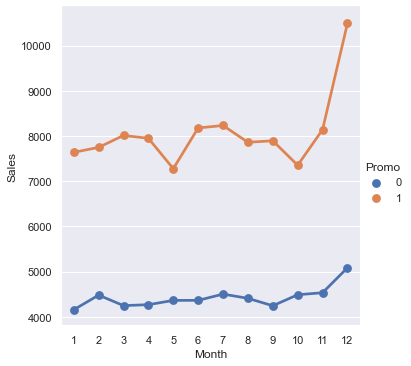

In [25]:
plt.figure(figsize=(12,7))
sns.factorplot(data = train_store, x ="Month", y = "Sales",
               hue = 'Promo',
              sharex=False)

<Figure size 864x504 with 0 Axes>

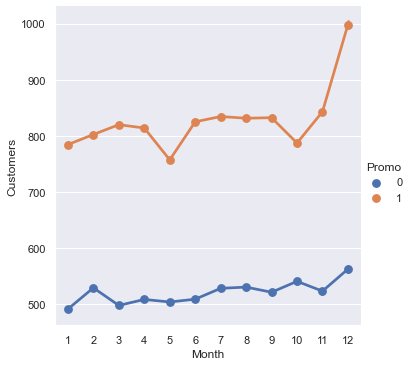

In [26]:
plt.figure(figsize=(12,7))
sns.factorplot(data = train_store, x ="Month", y = "Customers",
               hue = 'Promo',
              sharex=False)

Insight :-> Having a promotion increase the Sales and also the customers

### Could the promos be deployed in more effective ways? Which stores should promos be deployed in?

Number of Stores with less than 5143.545555555556 mean sales are 112


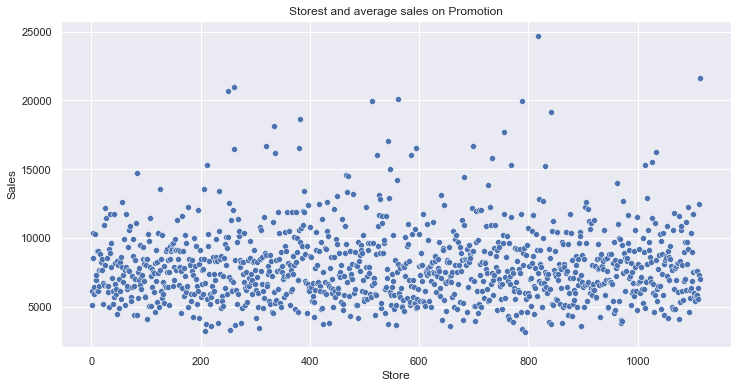

In [27]:
'''
Promo should be deployed on stores which have __ sales and __ customers (more, **less)?
'''

store_with_promo = train_store[train_store.Promo == 1]
result = store_with_promo[['Store','Sales', 'Customers']].groupby('Store').agg({"Sales":"mean", 'Customers':'sum'})

low_sales = result['Sales'].quantile(0.1) # least 10 percent sales
small_sales = result[(result['Sales'] <= low_sales)]

print(f"Number of Stores with less than {low_sales} mean sales are {small_sales.shape[0]}")
plot.scatter(result, "Store","Sales", 'Storest and average sales on Promotion')

Iinsight :-> so we have 112 stores which will need more promotion to increase the sales

### Trends of customer behavior during store open and closing times

<Figure size 864x504 with 0 Axes>

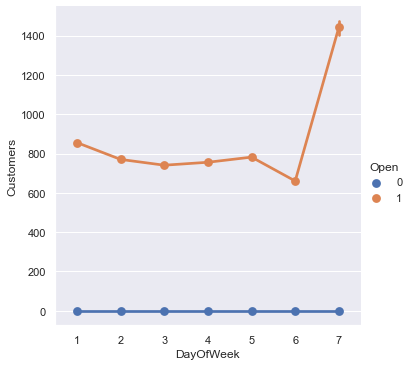

In [28]:
plt.figure(figsize=(12,7))
sns.factorplot(data = train_store, x ="DayOfWeek", y = "Customers",
               hue = 'Open',
              sharex=False)

### Which stores are opened on all weekdays? How does that affect their sales on weekends

Stores That work all Week are : 33


<Figure size 864x504 with 0 Axes>

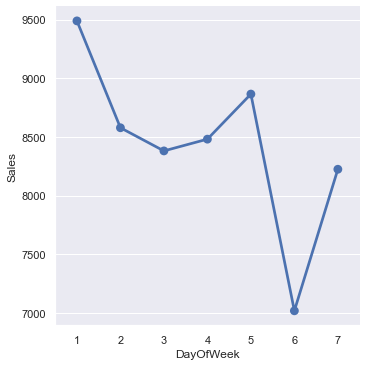

In [29]:
# stores, where their unique DayOfWeek count to 7
open_stores = train_store[train_store.Open == 1]
each_day = open_stores[['Store', 'DayOfWeek']].groupby('Store').nunique()

all_week_stores = each_day[each_day.DayOfWeek == 7]
stores_id = all_week_stores.reset_index()['Store']

get_stores = open_stores[(open_stores.Store.isin(set(stores_id)))]
get_stores = get_stores[['Store', 'Sales', 'Customers', 'DayOfWeek']]

week_sales = get_stores.groupby('DayOfWeek').mean().reset_index()

plt.figure(figsize=(12,7))
sns.factorplot(data = week_sales, x ="DayOfWeek", y = "Sales",
              sharex=False)
print(f'Stores That work all Week are : {all_week_stores.shape[0]}')

Insight :-> we have about 33 stores that work on all weedays, and the sales on week ends show rise from Saturday to sunday

### Check how the assortment type affects sales

INFO:root:util.py - get assortment for value of a
INFO:root:util.py - get assortment for value of b
INFO:root:util.py - get assortment for value of c


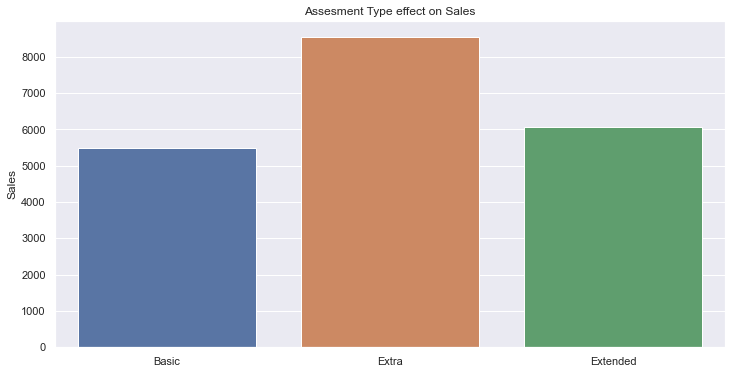

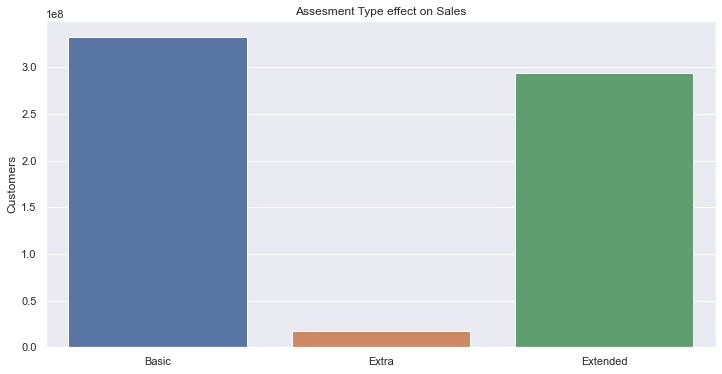

,Assortment,Sales,Customers
0,a,5481.026096,332766938
1,b,8553.931999,16972525
2,c,6058.676567,294302292


In [30]:
assortment = train_store.groupby('Assortment').agg({'Sales':'mean','Customers':'sum'}).reset_index()
assort_values = [util.get_assortment(x) for x in assortment.Assortment]

plot.bar(x=assort_values, y=assortment.Sales, title='Assesment Type effect on Sales')
plot.bar(x=assort_values, y=assortment.Customers, title='Assesment Type effect on Sales')
assortment
# sns.factorplot(data = assortment, x ="Assortment", y = "Customers",
#               sharex=False)

Insight:-> Stores with extra assortment have hights mean sales. but extra assortment got lowest customers

### How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centres, does the distance matter in that case?

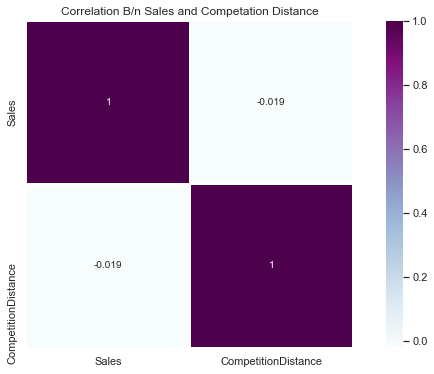

In [31]:
columns = train_store[['Sales', 'CompetitionDistance']]
plot.heatmap(columns, title='Correlation B/n Sales and Competation Distance')

Insight :-> The more the closer the stores the higher the sales, and the more the distant the lower the sales.

### How does the opening or reopening of new competitors affect stores?

In [26]:
train_store["CompetitionOpenSinceYear"].unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
          0., 2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961.,
       1995., 2001., 1990., 1994., 1900., 1998.])

<AxesSubplot:xlabel='ComeptitionBefore', ylabel='Sales'>

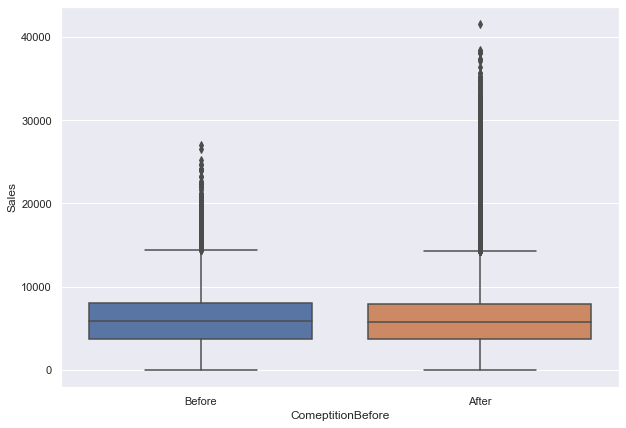

In [29]:
has_open_competition_df = train_store[train_store['CompetitionOpenSinceMonth'].notnull()]

has_open_competition_df["CompetitionOpenSinceYear"] = has_open_competition_df["CompetitionOpenSinceYear"].astype("int")
has_open_competition_df["CompetitionOpenSinceMonth"] = has_open_competition_df["CompetitionOpenSinceMonth"].astype("int")


sales_before_competition_open = has_open_competition_df[(has_open_competition_df["Year"] < has_open_competition_df["CompetitionOpenSinceYear"]) & (has_open_competition_df["Month"] < has_open_competition_df["CompetitionOpenSinceMonth"]) ]

sales_after_competition_open = has_open_competition_df[(has_open_competition_df["Year"] >= has_open_competition_df["CompetitionOpenSinceYear"]) & (has_open_competition_df["Month"] >= has_open_competition_df["CompetitionOpenSinceMonth"])]

sales_before_competition_open["ComeptitionBefore"]="Before"
sales_after_competition_open["ComeptitionBefore"]="After"

competition_sales_data=pd.concat([sales_before_competition_open,sales_after_competition_open])

plt.figure(figsize=(10, 7))
sns.boxplot(x='ComeptitionBefore', y='Sales', data=competition_sales_data)